### Problem Description

**From Bishop Ch 8.3.3:** We can illustrate the application of undirected graphs using an example of noise removal from a binary image. Although a very simple example, this is typical of more sophisticated applications. Let the observed noisy image be described by an array of binary pixel values $y_i \in \{−1, +1\}$, where the index $i = 1, . . . , D$ runs over all pixels. We shall suppose that the image is obtained by taking an unknown noise-free image, described by binary pixel values $x_i \in \{−1, +1\}$ and randomly flipping the sign of pixels with some small probability, like 10%.

### Load Image and Add Noise

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as imtool
from scipy.signal import convolve2d as conv2d

At first, we should be able to load images from file system to our program space. Here, we'll get help from package **matplotlib.image**, which should be already installed in your system with **matplotlib**. However, this image package natively support PNG files only. If you need support for other file type, you need another package called **Pillow** [(website)](https://pillow.readthedocs.io/en/latest/installation.html).

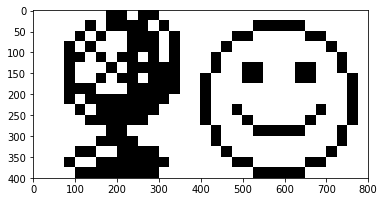

In [2]:
imorg = imtool.imread('img/imgdenoise/happyworld_big.png') # load image file
plt.imshow(imorg, cmap='gray')                                 # show binary image in gray scale

Second, we should be able to add noise to original image to generate noisy image we need for denoising. Here, I create a simple function '*addnoise*' to randomly flip pixels with given noise ratio.

Two thing need to be noticed here:
1. Image loaded by '*imread*' function get black as '0', while white as '1'. However, in our model, black should be '-1'. Therefore, I modify all '0' to '-1' before other operations.
2. Image represented by 'numpy.ndarray' in python. It is a class, which would pass reference instead of value in function calling. So, we need to make a copy of input image before add noise to it to avoid destory original image.

In [3]:
def addnoise(imorg, nratio=0.1):
    imnsy = imorg.copy()
    # convert '0' to '-1'
    imnsy[imnsy == 0] = -1
    # create random value to indicate flipping pixels
    index = np.random.rand(*imnsy.shape)
    # flip pixels to generate noisy image
    imnsy[index < nratio] *= -1
    
    return imnsy

Besides, it would be nice to show images side by side for comparison, and not to do it repeatly. Thus, I create a function '*showimgs*' to automatically put images in subplots.

In [4]:
def showimgs(*args, ncol=2):
    if not args:
        return
    # initialize figure with specific size
    plt.figure(figsize=(16, 10))
    # compose subplot index
    nrow = np.ceil(len(args) / ncol)
    subindex = nrow * 100 + ncol * 10
    # draw each image in subplot
    for i, img in enumerate(args):
        plt.subplot(subindex + i + 1)
        plt.imshow(img, cmap='gray')

Now, we can generate noisy image with specified noise ratio, and display it with original one side by side.

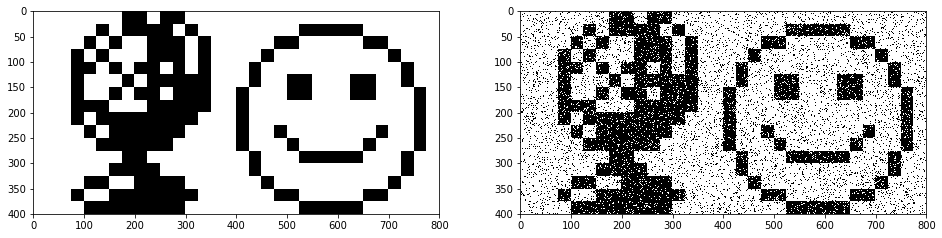

In [5]:
imnsy = addnoise(imorg, nratio = 0.1)
showimgs(imorg, imnsy)

### Markov Random Field Model for Image Denoising

![Markov Random Field Model](img/imgdenoise/model.png)

**From Bishop Ch 8.3.3:** 

Because the noise level is small, we know that there will be a strong correlation between $x_i$ and $y_i$. We also know that neighbouring pixels $x_i$ and $x_j$ in an image are strongly correlated. This prior knowledge can be captured using the Markov random field model whose undirected graph is shown in above figure. This graph has two types of cliques, each of which contains two variables. The cliques of the form $\{x_i, y_i\}$ have an associated energy function that expresses the correlation between these variables. We choose a very simple energy function for these cliques of the form $- \eta x_i y_i$ where $\eta$ is a positive constant. This has the desired effect of giving a lower energy (thus encouraging a higher probability) when $x_i$ and $y_i$ have the same sign and a higher energy when they have the opposite sign.

The remaining cliques comprise pairs of variables $\{x_i, x_j\}$ where $i$ and $j$ are indices of neighbouring pixels. Again, we want the energy to be lower when the pixels have the same sign than when they have the opposite sign, and so we choose an energy given by $− \beta x_i x_j$ where $\beta$ is a positive constant.

Because a potential function is an arbitrary, nonnegative function over a maximal clique, we can multiply it by any nonnegative functions of subsets of the clique, or equivalently we can add the corresponding energies. In this example, this allows us to add an extra term $\alpha x_i$ for each pixel $i$ in the noise-free image. Such a term has the effect of biasing the model towards pixel values that have one particular sign in preference to the other.

The complete energy function for the model then takes the form

$$E(X,Y) = \alpha\sum\limits_{i} x_i - \beta \sum\limits_{i,j} x_i x_j - \eta \sum\limits_{i} x_i y_i $$

which deﬁnes a joint distribution over $x$ and $y$ given by

$$p(x, y) = \frac{1}{Z} \exp\{-E(x,y)\}$$

### Solve the Model

Basic idea to solve this problem is updating the noisy image to decrease it's energy function. It's essentially an optimization process. A general way to do that is finding the gradient of energy function and modify original data according to it. We call this method **gradient descent**. 

This process can expressed as following function

In [6]:
def denoise(imnsy, efunc, showproc = False):
    # initialize recoverred image as noisy image
    imrec = imnsy.copy()
    # show noisy image
    if showproc:
        plt.imshow(imrec, cmap='gray')
        plt.title('Noisy Image')
        plt.show()
    # calculate energy function and its gradients
    E, dE = efunc(imrec, imnsy)
    # initialize temporal energy and iteration count
    Etmp, i = E + 1, 0
    # optimize energy function through iteration
    while Etmp > E:
        Etmp = E
        # update image by flipping all pixels, which could decrease energy function
        imrec[dE < 0] *= -1
        # calculate energy function with revised image
        [E, dE] = efunc(imrec, imnsy)
        # update iteration count
        i += 1
        # show revised image
        if showproc:
            plt.imshow(imrec, cmap='gray')
            plt.title('Recovered Image (Iter-%d)' % i)
            plt.show()
    # map '-1' to 0 in recovered image
    imrec[imrec == -1] = 0
    # return recovered image
    return imrec

Now, the only thing we need is the energy function. Before that, we should calculate the gradient of energy function. Here, we introduce a neighborhoods function $N(\cdot)$ to refer connected pixels. They are defined as a group of pixels that connected to $x_i$. In this case, we use 4-connectivity. Therefore, neighborhoods function returns 4 pixels for each query. And we note them as $\{N_j(\cdot), j \in [1,2,3,4]\}$. In the end, we transform energy function to

$$E(X,Y) = \alpha\sum\limits_{i} x_i - \beta \sum\limits_{i,j} x_i N_j(x_i) - \eta \sum\limits_{i} x_i y_i $$

When pixel $x_k$ flip to its opposite value. Image $X$ becomes image $X'$. Then energy of $X'$ can be expressed as follows

$$
\begin{array}{lll}
    E(X',Y) & = &  \alpha (\sum\limits_{i} x_i - 2 x_k) - \beta (\sum\limits_{i,j} x_i N_j(x_i) - \sum\limits_{j} 2 x_k N_j(x_k)) - \eta (\sum\limits_{i} x_i y_i - 2 x_k y_k) \\
            & = &  E(X,Y) - 2 x_k ( \alpha - \beta \sum\limits_{j} N_j(x_k) - \eta y_k) \\
    So, \quad \Delta E & = & - 2 x_k ( \alpha - \beta \sum\limits_{j} N_j(x_k) - \eta y_k)
\end{array}
$$

To implement it in a concise way, it is very important to understand filtering, which is a very important concept in image processing. Here, we use convolution operation, which is the mathematical form of filtering, to calculate $\beta$ term. And will use this concept to expand our model in later sections.

In [7]:
def defaultEnergyFunction(hidden, observation, alpha = 1, beta = 1, eta = 1):
    # create filter for beta term
    Tb = np.asarray([[0, 1.0, 0], [1.0, 0, 1.0], [0, 1.0, 0]])
    # convolve hidden image with term B's filter
    matB = conv2d(hidden, Tb, 'same')
    # calculate energy map
    mapE = hidden * (alpha - beta * matB - eta * observation)
    # get mean of matrix as energy
    E = np.mean(mapE)
    # calculate energy difference map
    dE = -2 * mapE
    
    return E, dE

Now, let's check the result of this program

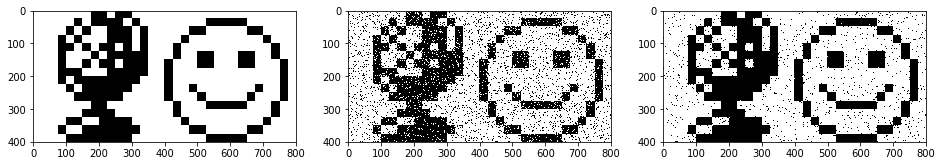

In [8]:
imrec = denoise(imnsy, defaultEnergyFunction)
showimgs(imorg, imnsy, imrec, ncol = 3)

### How to improve it?

The method to minimize energy function can be interpreted as trasforming images towards three different directions, which correspond to three items in energy function. The $\alpha$ item prefers white pixels, the $\beta$ item would act as an median filter in denoising, while the $\eta$ item tries to keep images as when it is given. Among them, the $\beta$ part as a median filter is some kind of abstraction from it mathematic form and perticular situation in this problem. $- \beta \sum_{i,j} x_i N_j(x_i)$ can be decomposited as $- \beta \sum_{i} x_i \sum_{j} N_j(x_i)$, and $\sum_{j} N_j(x_i)$ is representing a image that can be obtained by filtering image $X$ with template as folows:

<img src="img/imgdenoise/template-beta.png" width="300">

In which, purple presents a parameter $+1$, while white is $0$. If we call this template $T_{\beta}$, $\beta$ part energy function can be rewrited as $- \beta \sum_i x_i (X \ast T_{\beta})_i$. In the following part we would express $(X \ast T_{\beta})_i$ as $T_{\beta}(x_i)$ for convenient.

In this problem, it is very interesting that $\beta$ item in energy function actually acts a median filter, which is a non-linear filter. This is because $X$ is a binary image with pixel value $-1$ and $+1$. When $T_{\beta}$ convoluse with image, it's result is actually corresponding to the majority in neightborhood area. The preference of low energy would make denoising procedure choose the majority in neighborhood area as the value of center pixel. If there is equal number of two type of pixels, the convolution would be $0$, and the mechanism of computer program for this procedure would prefer to keep original value of center pixel too. This is just what does median filter do. It's amazing because it obtain a non-linear result by linear way.

At first, we create a energy function only contains $\beta$ term with anonymous function.

In [9]:
medFilter = lambda hidden, observation: defaultEnergyFunction(hidden, observation,
                                                              alpha=0, beta=1, eta=0)

And then, let's try to use $\beta$ term only to see what happend

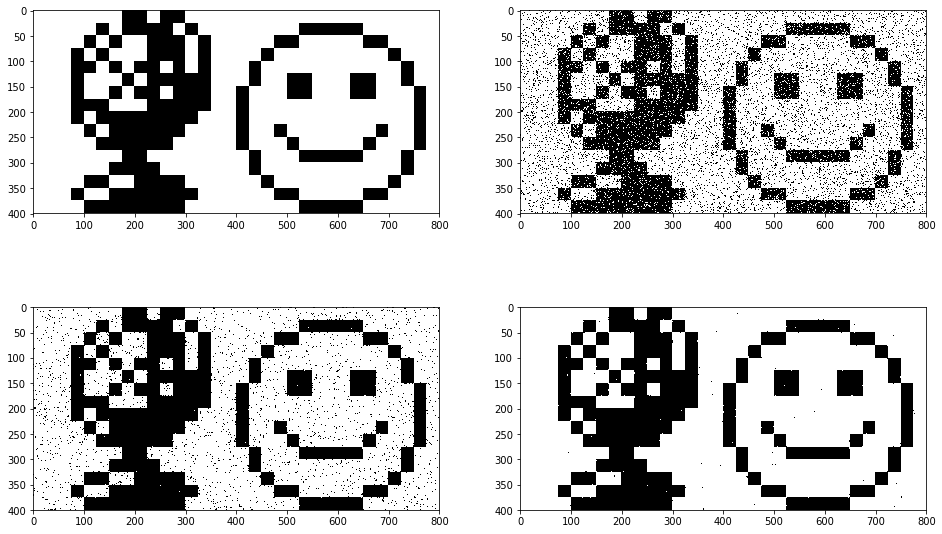

In [10]:
imrecMed = denoise(imnsy, medFilter)
showimgs(imorg, imnsy, imrec, imrecMed)

Better, right? Can we improve it even more?

### Extension

The extension to default energy function we make here is majorly bringing more filter templates. The revised function can be express as follows
$$\begin{array}{rcl}
E(X,Y) & = & -\alpha \sum\limits_{i} max_{j}(x_iT_{\alpha}^{j}(x_i)) - 
					\sigma \sum\limits_{i} max_{j}(x_iT_{\sigma}^{j}(x_i)) \\
       &   & \quad - \sum\limits_{i} x_i [\beta T_{\beta}(x_i) + \gamma T_{\gamma}(x_i) +
					\phi T_{\phi}(x_i)] - \eta \sum\limits_{i} x_i y_i
\end{array}$$

Among them, $T_{\alpha}$ and $T_{\sigma}$ have a difference format because they are both a group of templates. Main ideas for these two template are to preserve lines and edges separately. This is realized by matching patterns of lines or edges, and then make sure energy decreasing direction would prefer to protect them. Other templates are easy to understand. Among them $T_{\beta}$, $T_{\gamma}$, and $T_{\phi}$ are three median filters in different shape and scale. Following figures show these templates without $T_{\beta}$, which has shown before, in intuitive way. Purple, white, and black blocks correspond parameters $+1$, $0$, and $-1$ separately.

$T_{\alpha}$                            |  $T_{\gamma}$
----------------------------------------|----------------------------------------- 
<img src="img/imgdenoise/template-alpha.png" width="300">  |  <img src="img/imgdenoise/template-gamma.png" width="300">

$T_{\phi}$                            |  $T_{\sigma}$
--------------------------------------|-----------------------------------------
<img src="img/imgdenoise/template-phi.png" width="300">  |  <img src="img/imgdenoise/template-sigma.png" width="300">

You will found all the templates shown here are in the scare of $5 \times 5$, this is because $3 \times 3$ templates bring high fake positive rates\footnotemark. As you saw, template $T_{\alpha}$ and $T_{\sigma}$ have not travaled out all directions. This is a trade-off between computational complexity and performance.

At first, let define the extended energy function

In [11]:
def extendEnergyFunction(hidden, observation, 
                         alpha=1, beta=1, gamma=1, phi=1, sigma=1, eta=1):
    # template alpha
    Ta = np.asarray([[[-1,-1,-1,-1,1],[-1,-1,-1,1,-1],[-1,-1,0,-1,-1],[-1,1,-1,-1,-1],[1,-1,-1,-1,-1]],
                     [[-1,-1,1,-1,-1],[-1,-1,1,-1,-1],[-1,-1,0,-1,-1],[-1,-1,1,-1,-1],[-1,-1,1,-1,-1]],
                     [[1,-1,-1,-1,-1],[-1,1,-1,-1,-1],[-1,-1,0,-1,-1],[-1,-1,-1,1,-1],[-1,-1,-1,-1,1]],
                     [[-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1],[1,1,0,1,1],[-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1]]])
    # template beta
    Tb = np.asarray([[0, 1, 0], [1, 0, 1], [0, 1, 0]])
    # template gamma
    Tr = np.asarray([[1,1,1,1,1],[1,0,0,0,1],[1,0,0,0,1],[1,0,0,0,1],[1,1,1,1,1]])
    # template phi
    Tp = np.asarray([[0,0,1,0,0],[0,0,1,0,0],[1,1,0,1,1],[0,0,1,0,0],[0,0,1,0,0]])
    # template sigma
    Ts = np.asarray([[[1,-1,-1,-1,-1],[1,0,-1,-1,-1],[1,1,0,-1,-1],[1,1,1,0,-1],[1,1,1,1,1]],
                     [[1,1,1,-1,-1],[1,1,0,-1,-1],[1,1,0,-1,-1],[1,1,0,-1,-1],[1,1,1,-1,-1]],
                     [[1,1,1,1,1],[1,1,1,0,-1],[1,1,0,-1,-1],[1,0,-1,-1,-1],[1,-1,-1,-1,-1]],
                     [[1,1,1,1,1],[1,1,1,1,1],[1,0,0,0,1],[-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1]],
                     [[1,1,1,1,1],[-1,0,1,1,1],[-1,-1,0,1,1],[-1,-1,-1,0,1],[-1,-1,-1,-1,1]],
                     [[-1,-1,1,1,1],[-1,-1,0,1,1],[-1,-1,0,1,1],[-1,-1,0,1,1],[-1,-1,1,1,1]],
                     [[-1,-1,-1,-1,1],[-1,-1,-1,0,1],[-1,-1,0,1,1],[-1,0,1,1,1],[1,1,1,1,1]],
                     [[-1,-1,-1,-1,-1],[-1,-1,-1,-1,-1],[1,0,0,0,1],[1,1,1,1,1],[1,1,1,1,1]]])
    
    # generate parameter matrix alpha
    matA = np.empty(hidden.shape)
    for T in Ta:
        matA = np.maximum(matA, hidden * conv2d(hidden, T, 'same'))
    # generate parameter matrix beta
    matB = conv2d(hidden, Tb, 'same')
    # generate parameter matrix gamma
    matR = conv2d(hidden, Tr, 'same')
    # generate parameter matrix phi
    matP = conv2d(hidden, Tp, 'same')
    # generate parameter matrix sigma
    matS = np.empty(hidden.shape)
    for T in Ts:
        matS = np.maximum(matS, hidden * conv2d(hidden, T, 'same'))
        
    # calculate energy map
    mapE = -alpha*matA - sigma*matS - hidden*(beta*matB + gamma*matR + phi*matP + eta*observation)
    # get energy value as mean of map
    E = np.mean(mapE)
    # calculate energy difference map
    dE = -2 * mapE
    
    return E, dE

Then, let's solve the problem in this exercise. Even though median filter perform rather well, it's not enough. There still are some spots existed. This is because $3 \times 3$ cannot remove noise bigger than 2 pixels. A straight forward way to solve this problem is extend median filter to $5 \times 5$. In our templates, there are two options, $T_{\gamma}$ and $T_{\phi}$. $T_{\gamma}$ should work with $T_{\beta}$, can process $3 \times 3$ noise, but have a higher false positive rate than $T_{\phi}$, which can work alone. 

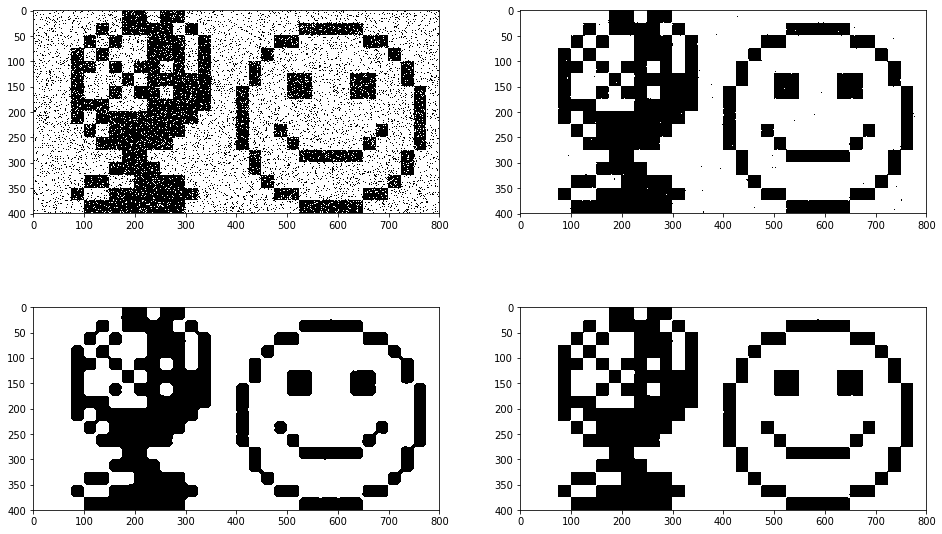

In [12]:
medFilterExt = lambda hidden, observation: extendEnergyFunction(hidden, observation, 
                                                                alpha=0, beta=1, gamma=0.1, 
                                                                phi=0, sigma=0, eta=0)

medFilterLarge = lambda hidden, observation: extendEnergyFunction(hidden, observation, 
                                                                  alpha=0, beta=0, gamma=0, 
                                                                  phi=1, sigma=0, eta=0)

# denoise image with new energy functions
imrecMedExt = denoise(imnsy, medFilterExt)
imrecMedLag = denoise(imnsy, medFilterLarge)

# compare result from different median filter
showimgs(imnsy, imrecMed, imrecMedExt, imrecMedLag)

It seems $T_{\beta}$ and $T_{\gamma}$ removed noise left when use $T_{\beta}$ alone but corroded corners. And $T_{\phi}$ is almost perfect to this picture.

These two methods both have problem on edges. We can use protective template sets $T_\alpha$ and $T_\sigma$ working with median filters. A simple conclusion is that protective template would prevent edge corrosion and speed up optimization. But, they are obviously not capable to improve denoising performance further.

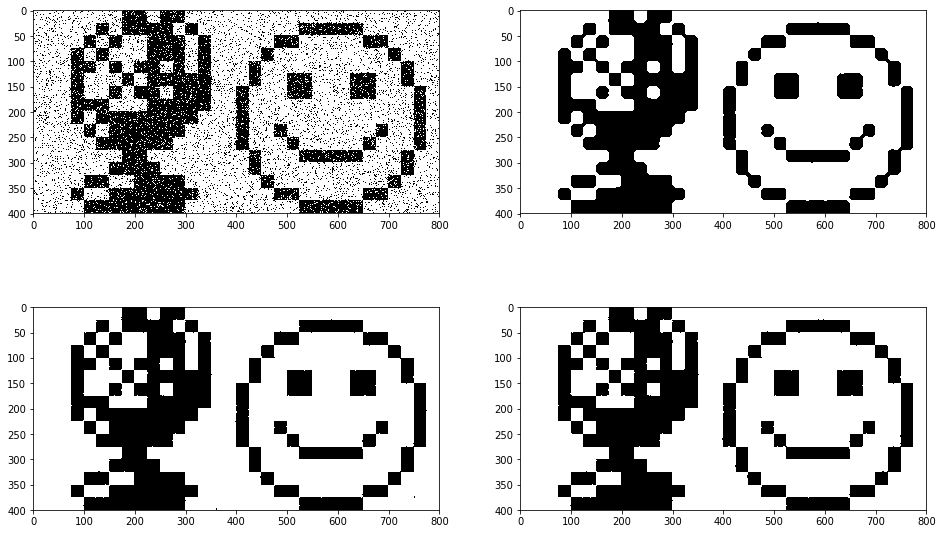

In [13]:
medFilterProtectA = lambda hidden, observation: extendEnergyFunction(hidden, observation, 
                                                                     alpha=0.1, beta=1, gamma=0.1, 
                                                                     phi=0, sigma=0, eta=0)

medFilterProtectS = lambda hidden, observation: extendEnergyFunction(hidden, observation, 
                                                                     alpha=0, beta=1, gamma=0.1, 
                                                                     phi=0, sigma=0.1, eta=0)

# denoise image with new energy functions
imrecMedProtectA = denoise(imnsy, medFilterProtectA)
imrecMedProtectS = denoise(imnsy, medFilterProtectS)

# compare result from different median filter
showimgs(imnsy, imrecMedExt, imrecMedProtectA, imrecMedProtectS)

Even though median filters perform very well on high-definition images, when it comes to low-definition they destory whole image. You should be able to test it yourself now.

Do you have any other ideas? Please try yourself.